# ISMIR 2018 Tutorial
# Deep Learning for Music Information Retrieval

## Part 1: Convoluational Neural Networks for Instrumental, Genre and Mood Detection in Music

Author: Thomas Lidy

This tutorial shows how different Convolutional Neural Network architectures are used for:
* Instrumental vs. Vocal Detection:  detecting whether a piece of music is instrumental or contains vocals
* Genre Classification
* Mood Recognition

The data set used is the [MagnaTagATune Dataset](http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset), but a smaller subset of it, with only 1 sample excerpt of each of the original audio files.

It consists of 5405 files, each 30 seconds long. 

The annotations for this dataset contain a multitude of tags, including some that hint at whether the file is instrumental or vocal.

### Table of Contents

This tutorial contains:
* Loading and Preprocessing of Audio files
* Loading class files from CSV and using Label Encoder
* Audio Preprocessing: Generating log Mel spectrograms
* Standardization of Data
* Convolutional Neural Networks
* Train/Test set split

* Instrumental vs. Vocal Detection
* Genre Classification
* Mood Recognition

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

### Requirements

* Python >= 3.5
* Keras >= 2.1.1
* Tensorflow
* scikit-learn >= 0.18
* Pandas
* Librosa
* MatplotLib

### Download Data

If you haven't already (follwing [README](../README.md#download-prepared-datasets)), 
please download the following data sets for this tutorial:

#### MagnaTagAtune

Prepared Spectrograms: https://owncloud.tuwien.ac.at/index.php/s/VyDlQKmsA2EFAhv (209MB)

Unzip them into a folder, e.g. inside this Tutorial folder, and adapt the following `DATA_PATH` variable:

In [1]:
# SET PATH OF DOWNLOADED DATA HERE
# '.' is ok if you unzipped the files inside this tutorials folder

DATA_PATH = '.'

In [10]:
import os

SPECTROGRAM_FILE = os.path.join(DATA_PATH, 'ISMIR2018_tut_prepared_features/ISMIR2018_tut_Magnagtagatune_spectrograms.npz')

AUDIO_PATH = os.path.join(DATA_PATH, 'mp3_full')
META_PATH = os.path.join(DATA_PATH, 'metadata')


#NPZ_FILE = '/home/tlidy/data/mel_spectrogram_segments_96x1366.npz'

In [2]:
# IF YOU USE A GPU, you may set which GPU(s) to use here:
os.environ["CUDA_VISIBLE_DEVICES"]="2" #"0,1,2,3" 

In [5]:
# General Imports

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation

# Deep Learning

import keras
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

# Machine Learning preprocessing and evaluation

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
# local imports for audio reading and processing
#import audio_spectrogram as rp
#from audiofile_read import audiofile_read

## Load the Metadata

The tab-separated file contains pairs of filename TAB class.

In [17]:
csv_file = os.path.join(META_PATH,'annotations_final_subsample.csv')

# we select the last column (-1) as the index column (= filename)
metadata = pd.read_csv(csv_file, index_col=0, sep='\t')

metadata.shape

(3023, 189)

In [11]:
metadata.head()

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,1119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,6021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,11847,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,17119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,25118,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-06-cyead-378-407.mp3,26533,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-07-telekonology-117-146.mp3,33637,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0/american_bach_soloists-j_s__bach__cantatas_volume_v-02-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_ii_recitative__gleichwie_der_regen_und_schnee-30-59.mp3,5864,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# we make the clip_id the index and drop the orignal mp3_path
# as we later align by clip_id

metadata.set_index('clip_id', inplace=True)
metadata.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
clip_id,,,,,,,,,,,,,,,,,,,,,
1119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 1) Instrumental vs. Vocal Detection

this is a binary classification task (output decision is between 0 and 1)

### Create 2 classes from a list of tags

There are plenty of "tags" in this data set which hint at wether a track is "vocal" or "instrumental". We group these tags and finally come up with 1 boolean column saying whether a track is "vocal" or "instrumental".

In [22]:
tags_vocal = ['singer', 'female singing', 'female opera', 'male vocal', 'vocals', 'men', 'female', 'female voice', 'voice', 'male voice', 'girl', 'chanting', 'talking', 'choral', 'male singer', 'man singing', 'male opera', 'chant', 'man', 'female vocal', 'male vocals', 'vocal', 'woman', 'woman singing', 'singing', 'female vocals', 'voices', 'choir', 'female singer', 'women', 'choir', 'women']

tags_instrumental = ['instrumental', 'no voice', 'no voices', 'no vocals', 'no vocal', 'no singing', 'no singer']

In [23]:
metadata[tags_vocal].head()

,singer,female singing,female opera,male vocal,vocals,men,female,female voice,voice,male voice,...,woman,woman singing,singing,female vocals,voices,choir,female singer,women,choir,women
clip_id,,,,,,,,,,,,,,,,,,,,,
1119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# set vocal to True of any of the tags_vocal are 1
gt_vocal = metadata[tags_vocal].any(axis=1)
gt_vocal.head()

clip_id
1119     False
6021     False
11847    False
17119    False
25118    False
dtype: bool

In [25]:
# set instrumental to True of any of the tags_instrumental are 1
gt_instrumental = metadata[tags_instrumental].any(axis=1)
gt_instrumental.head()

clip_id
1119     False
6021     False
11847    False
17119    False
25118     True
dtype: bool

<b>We can only use the tag if EITHER instrumental OR vocal is True.</b><br>
If both of them are True or both of them are False, we cannot trust the groundtruth data. Ergo we have to remove these and retain only the others.

In [26]:
retain = np.logical_xor(gt_vocal,gt_instrumental)
retain.head()

clip_id
1119     False
6021     False
11847    False
17119    False
25118     True
dtype: bool

In [28]:
n_orig = len(gt_vocal)
n_retain = sum(retain)

print("For instrumental vs. vocal, from originally", n_orig, "input examples, we can only retain",n_retain, "trusted ones in our groundtruth")

For instrumental vs. vocal, from originally 3023 input examples, we can only retain 959 trusted ones in our groundtruth


In the end we cut from gt_vocal only the instances to retain. If they are True they are vocal, if they are False, they are instrumental:

In [29]:
gt_final = gt_vocal[retain]
gt_final.head(9)

clip_id
25118    False
11264     True
30129     True
34405     True
38391     True
44927     True
49435     True
51060     True
52343     True
dtype: bool

In [30]:
print(str(sum(gt_final)) + " vocal tracks")

671 vocal tracks


In [31]:
print(str(sum(np.logical_not(gt_final))) + " instrumental tracks")

288 instrumental tracks


<b>Create two lists: one with the clip_ids and one with associated classes</b>

In [34]:
# index in list of clip_ids
clip_ids = gt_final.index.tolist()
# convert boolean to int and store in other list
classes = (gt_final * 1).tolist()

In [35]:
clip_ids[0:5]

[25118, 11264, 30129, 34405, 38391]

In [36]:
classes[0:5]

[0, 1, 1, 1, 1]

In [37]:
# convert to Numpy array as needed by Keras
classes = np.array(classes)
classes[0:5]

array([0, 1, 1, 1, 1])

## Load Audio Spectrograms

We have pre-processed the audio files already and extracted Mel spectrograms. We load these from a Numpy .npz file, which contains the spectrograms and also the associated clip ids.

In [50]:
with np.load(SPECTROGRAM_FILE) as npz:
    spectrograms = npz["features"]
    spec_clip_ids = npz["clip_id"]
    
spectrograms.shape

(6380, 80, 80)

In [51]:
len(spec_clip_ids)

6380

In [57]:
# create dataframe that associates the order of the spectrograms with the clip_ids
spectrograms_clip_ids = pd.DataFrame({"spec_id": np.arange(spectrograms.shape[0])}, index = spec_clip_ids)
spectrograms_clip_ids.head()

,spec_id
66,0
90,1
91,2
94,3
105,4


In [60]:
len(clip_ids)

959

In [62]:
len(set(clip_ids).intersection(set(spec_clip_ids)))

273

In [59]:
spectrograms_clip_ids.loc[clip_ids]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,spec_id
25118,NaN
11264,NaN
30129,NaN
34405,NaN
38391,1575.0
44927,NaN
49435,NaN
51060,NaN
52343,NaN
53426,6293.0


### Show Mel Spectrogram (1 example just for illustration)

In [39]:
# you can skip this if you do not have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [42]:
# take first spectrogram as an example
spec = spectrograms[0]

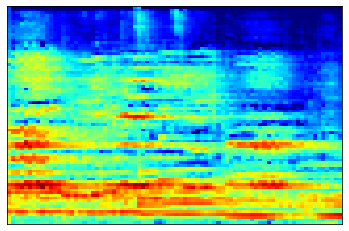

In [44]:
# plot it 
fig = plt.imshow(spec, origin='lower', aspect='auto')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Align Metadata and Spectrograms

In [72]:
metadata_genre = pd.read_csv("./metadata/ismir2018_tut_part_2_genre_metadata.csv", index_col=0)
metadata_genre.shape

(2617, 10)

In [73]:
metadata_genre.head()

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
15066,32957,D:/Research/Data/MIR/MagnaTagATune/mp3_full/7/...,7,Reckless Woman Blues,Jag,Cypress Grove Blues,http://www.magnatune.com/artists/albums/jag-cy...,117,146,http://he3.magnatune.com/all/07-Reckless%20Wom...
5256,11455,D:/Research/Data/MIR/MagnaTagATune/mp3_full/3/...,3,All Worn Out,Jag,Four Strings,http://www.magnatune.com/artists/albums/jag-four/,30,59,http://he3.magnatune.com/all/03-All%20Worn%20O...
23603,52328,D:/Research/Data/MIR/MagnaTagATune/mp3_full/3/...,14,You're Cheatin' On Me,Jag,Four Strings,http://www.magnatune.com/artists/albums/jag-four/,88,117,http://he3.magnatune.com/all/14-You're%20Cheat...
24083,53525,D:/Research/Data/MIR/MagnaTagATune/mp3_full/7/...,16,Baby Don't Say That,Jag,Cypress Grove Blues,http://www.magnatune.com/artists/albums/jag-cy...,88,117,http://he3.magnatune.com/all/16-Baby%20Don't%2...
20833,45825,D:/Research/Data/MIR/MagnaTagATune/mp3_full/4/...,11,How the story goes,Burnshee Thornside,The Art of Not Blending In,http://www.magnatune.com/artists/albums/burnsh...,146,175,http://he3.magnatune.com/all/11-How%20the%20st...


## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

We use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).
Here, we use <b>attribute-wise standardization</b>, i.e. each pixel is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

('Flat' standardization would also be possible, but we have seen benefits of attribut-wise standardization in our experiments).

We use the StandardScaler from the scikit-learn package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first.

In [64]:
def standardize(data):
    # vectorize before standardization (cause scaler can't do it in that format)
    N, ydim, xdim = data.shape
    data = data.reshape(N, xdim*ydim)

    # standardize
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    # reshape to original shape
    return data.reshape(N, ydim, xdim)

In [65]:
data = standardize(spectrograms)

# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were initially made for image data, we need to add a dimension for the color channel to the data. RGB images typically have a 3rd dimension with the color. 

<b>Spectrograms, however, are considered like greyscale images, as in the previous tutorial.
Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [67]:
def add_channel(data, n_channels=1):
    # n_channels: 1 for grey-scale, 3 for RGB, but usually already present in the data
    
    N, ydim, xdim = data.shape

    if keras.backend.image_data_format() == 'channels_last':  # TENSORFLOW
        # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
        data = data.reshape(N, ydim, xdim, n_channels)
    else: # THEANO
        # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
        data = data.reshape(N, n_channels, ydim, xdim)
        
    return data

In [68]:
data = add_channel(data, n_channels=1)
data.shape

(6380, 80, 80, 1)

In [69]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Note: 
For demo purposes we use only 1 split here. A better way to do it is to use **Cross-Validation**, doing the split multiple times, iterating training and testing over the splits and averaging the results.

In [74]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [75]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

ValueError: Found input variables with inconsistent numbers of samples: [6380, 959]

In [37]:
print(train_set.shape)
print(test_set.shape)

(719, 96, 683, 1)
(240, 96, 683, 1)


In [38]:
print("Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes))

Class Counts: Class 0: 216 Class 1: 503


# Creating Neural Network Models in Keras

## Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks.

Try: (comment/uncomment code in the following code block)
* 1 Layer
* 2 Layer
* more conv_filters
* Dropout

In [ ]:
#np.random.seed(0) # make results repeatable

model = Sequential()

#conv_filters = 16   # number of convolution filters (= CNN depth)
conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, (3, 3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

# Layer 2
model.add(Convolution2D(conv_filters, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

## Training the CNN

In [ ]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)### Verifying Accuracy on Test Set

### Verifying Accuracy on Test Set

In [ ]:
# always execute this, and then a box of accuracy_score below to print the result
test_pred = model.predict_classes(test_set)

In [ ]:
# 1 layer
accuracy_score(test_classes, test_pred)

In [ ]:
# 2 layers
accuracy_score(test_classes, test_pred)

In [ ]:
# 2 layers + 32 convolution filters
accuracy_score(test_classes, test_pred)

In [ ]:
# 2 layer + 32 convolution filters + Dropout
accuracy_score(test_classes, test_pred)

## Additional Parameters & Techniques

Try out more parameters and techniques: (comment/uncomment code blocks below)
* Adding ReLU activation
* Adding Batch normalization
* Adding Dropout

In [ ]:
model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
filter_size = (3,3)
pool_size = (2,2)

# Layer 1
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.3))

# Layer 2
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.1))

# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# MIREX 2015 model
model = Sequential()

conv_filters = 15   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, (12, 8), padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(Activation('sigmoid')) 
model.add(MaxPooling2D(pool_size=(2, 1))) 
#model.add(Dropout(0.3))


# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid'))  
#model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# Compiling and training the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

In [ ]:
# Verifying Accuracy on Test Set

test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

## TODO? Parallel CNNs

It has been discovered, that CNNs for music work best, when they have one filter that is detecting frequencies in the vertical axis, and nother filter that is focused on the time axis, i.e. detecting rhythm. Consequently, this is realized in a parallel CNN, where 2 layers are not stacked after each other, but first run independently in parallel with their output being merged later.

To create parallel CNNs we need a "graph-based" model. In Keras 1.x this is realized via the functional API of the Model() class.
We use it to create two CNN layers that run in parallel to each other and are merged subsequently.
In the functional API, you pass the name of the previous layer in (brackets) after defining the next layer.

In [76]:
# TODO import from Part1a Music _speech

## Compact CNN

This is a 5 layer Convolutional Neural Network inspired and adapted from Keunwoo Choi (https://github.com/keunwoochoi/music-auto_tagging-keras)

It is specified using Keras' functional Model Graph API (https://keras.io/models/model/).

In [39]:
data.shape

(959, 96, 683, 1)

In [40]:
def CompactCNN(input_shape, nb_conv, nb_filters, n_mels, normalize, nb_hidden, dense_units, 
               output_shape, activation, dropout, multiple_segments=False, graph_model=False, input_tensor=None):
    
    melgram_input = Input(shape=input_shape)

    if n_mels >= 256:
        poolings = [(2, 4), (4, 4), (4, 5), (2, 4), (4, 4)]
    elif n_mels >= 128:
        poolings = [(2, 4), (4, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 96:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 72:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (3, 4)]
    elif n_mels >= 64:
        poolings = [(2, 4), (2, 4), (2, 5), (2, 4), (4, 4)]

    # Determine input axis
    if keras.backend.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2
            
    # Input block
    #x = BatchNormalization(axis=time_axis, name='bn_0_freq')(melgram_input)
        
    if normalize == 'batch':
        x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)
    elif normalize in ('data_sample', 'time', 'freq', 'channel'):
        x = Normalization2D(normalize, name='nomalization')(melgram_input)
    elif normalize in ('no', 'False'):
        x = melgram_input

    # Conv block 1
    x = Convolution2D(nb_filters[0], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[0], name='pool1')(x)
        
    # Conv block 2
    x = Convolution2D(nb_filters[1], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[1], name='pool2')(x)
        
    # Conv block 3
    x = Convolution2D(nb_filters[2], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[2], name='pool3')(x)
    
    # Conv block 4
    if nb_conv > 3:        
        x = Convolution2D(nb_filters[3], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn4')(x)
        x = ELU()(x)   
        x = MaxPooling2D(pool_size=poolings[3], name='pool4')(x)
        
    # Conv block 5
    if nb_conv == 5:
        x = Convolution2D(nb_filters[4], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn5')(x)
        x = ELU()(x)
        x = MaxPooling2D(pool_size=poolings[4], name='pool5')(x)

    # Flatten the outout of the last Conv Layer
    x = Flatten()(x)
      
    if nb_hidden == 1:
        x = Dropout(dropout)(x)
        x = Dense(dense_units, activation='relu')(x)
    elif nb_hidden == 2:
        x = Dropout(dropout)(x)
        x = Dense(dense_units[0], activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(dense_units[1], activation='relu')(x) 
    else:
        raise ValueError("More than 2 hidden units not supported at the moment.")
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name = 'output')(x)
    
    # Create model
    model = Model(melgram_input, x)
    
    return model

### Set model parameters



In [41]:
# number of Convolutional Layers
nb_conv_layers = 4

# number of Filters in each layer
nb_filters = [64,64,64,128,128]

# number of hidden layers at the end of the model
nb_hidden = 1 # 2

# how many neurons in each hidden layer
dense_units = 128 #[128,56]

# how many output units
# IN A BINARY CLASSIFICATION TASK with 2 possible outputs, 1 single output unit is sufficent (deciding between 0 and 1)
output_shape = 1

# which activation function to use for OUTPUT layer
# IN A BINARY CLASSIFICATION TASK sigmoid activation is the right choice (activating betwee 0 and 1)
output_activation = 'sigmoid'

# which type of normalization
normalization = 'batch'

# droupout
dropout = 0.2

In [42]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, n_mels = 96, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 683, 1)        0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 96, 683, 1)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 683, 64)       640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 96, 683, 64)       256       
_________________________________________________________________
elu_1 (ELU)                  (None, 96, 683, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 170, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 170, 64)       36928     
__________

## Training Setup

In [44]:
# Loss

# the loss for a binary classification task is BINARY crossentropy
loss = 'binary_crossentropy' 

In [45]:
# Optimizers

# simple case:
# Stochastic Gradient Descent
#optimizer = 'sgd' 

# advanced:
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)#lr=0.001 decay = 0.03
adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

# We use mostly ADAM
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004)

# choose
optimizer = adam

In [46]:
# Metrics

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = ['accuracy', precision, recall]

In [47]:
# Other
batch_size = 32 

epochs = 30

validation_split=0.1 

#n_folds = 5
random_seed = 0

callbacks = None

### Tensorboard (optional)

In [48]:
from keras.callbacks import TensorBoard

In [49]:
#home_dir = os.getenv("HOME")

#TB_LOGDIR = os.path.join(home_dir, "./tensorboard")

TB_LOGDIR = "./tensorboard"

experiment_name = "instrumental"

tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)

In [50]:
# OPTIONAL
# new tensorboard callback at each training
# tensorboard_run_id = "Vocal_magna_2seg_adam_compact_128fbis_128h"
# tb_logdir = "%s/%s_fold%d %s" %(tb_logdir, tensorboard_run_id, fold, strftime("%Y-%m-%d %H:%M:%S", localtime()))

In [51]:
print("Execute the following in a terminal:\n")
print("tensorboard --logdir=" + TB_LOGDIR)

Execute the following in a terminal:

tensorboard --logdir=/home/schindler/tensorboard


In [52]:
# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# + add to callbacks
callbacks = [tensorboard]

Then open Tensorboard in browser:

http://localhost:6006

## Training

In [53]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

binary_crossentropy
['accuracy', <function precision at 0x7f68f5674598>, <function recall at 0x7f68f5674510>]
Batch size: 32 Epochs: 30


In [54]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [55]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [56]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

Train on 647 samples, validate on 72 samples
Epoch 1/30
647/647 [==============================] - 5s 8ms/step - loss: 0.9370 - acc: 0.6832 - precision: 0.7656 - recall: 0.8142 - val_loss: 0.7402 - val_acc: 0.7500 - val_precision: 0.7464 - val_recall: 1.0000
Epoch 2/30
647/647 [==============================] - 3s 4ms/step - loss: 0.5887 - acc: 0.7172 - precision: 0.7577 - recall: 0.8972 - val_loss: 0.7986 - val_acc: 0.7361 - val_precision: 0.7500 - val_recall: 0.9630
Epoch 3/30
647/647 [==============================] - 3s 4ms/step - loss: 0.4654 - acc: 0.7697 - precision: 0.8023 - recall: 0.8973 - val_loss: 0.4519 - val_acc: 0.7917 - val_precision: 0.8774 - val_recall: 0.8317
Epoch 4/30
647/647 [==============================] - 3s 4ms/step - loss: 0.3602 - acc: 0.8454 - precision: 0.8898 - recall: 0.8973 - val_loss: 0.4908 - val_acc: 0.8194 - val_precision: 0.9011 - val_recall: 0.8494
Epoch 5/30
647/647 [==============================] - 3s 4ms/step - loss: 0.3200 - acc: 0.8655 - pr

### Verifying Accuracy on Test Set

In [57]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob[0:10]

array([[1.0000000e+00],
       [9.2034358e-01],
       [8.6222380e-01],
       [9.9999821e-01],
       [8.7224616e-04],
       [1.5277641e-02],
       [9.9998999e-01],
       [9.9984491e-01],
       [9.9999988e-01],
       [5.1573163e-01]], dtype=float32)

In [58]:
# to get the predicted class we have to round 0 < 0.5 > 1
test_pred = np.round(test_pred_prob)
test_pred[0:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [59]:
# get final Accuracy
accuracy_score(test_classes, test_pred)

0.8708333333333333

# 2) Genre Classification

this is a single-label / multi-class task (multiple categories, but decision needs to be for 1 of them)

## Load Metadata

## Prepare Metadata

we start with the original metadata

In [60]:
metadata.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# check which columns are available
tags_all = metadata.columns.tolist()
print(tags_all)

['no voice', 'singer', 'duet', 'plucking', 'hard rock', 'world', 'bongos', 'harpsichord', 'female singing', 'clasical', 'sitar', 'chorus', 'female opera', 'male vocal', 'vocals', 'clarinet', 'heavy', 'silence', 'beats', 'men', 'woodwind', 'funky', 'no strings', 'chimes', 'foreign', 'no piano', 'horns', 'classical', 'female', 'no voices', 'soft rock', 'eerie', 'spacey', 'jazz', 'guitar', 'quiet', 'no beat', 'banjo', 'electric', 'solo', 'violins', 'folk', 'female voice', 'wind', 'happy', 'ambient', 'new age', 'synth', 'funk', 'no singing', 'middle eastern', 'trumpet', 'percussion', 'drum', 'airy', 'voice', 'repetitive', 'birds', 'space', 'strings', 'bass', 'harpsicord', 'medieval', 'male voice', 'girl', 'keyboard', 'acoustic', 'loud', 'classic', 'string', 'drums', 'electronic', 'not classical', 'chanting', 'no violin', 'not rock', 'no guitar', 'organ', 'no vocal', 'talking', 'choral', 'weird', 'opera', 'soprano', 'fast', 'acoustic guitar', 'electric guitar', 'male singer', 'man singing',

In [62]:
len(tags_all)

188

In [63]:
genres = ['classical', 'rock', 'pop', 'jazz', 'techno'] # 'electronic', ## too little data: , 'reggae', 'metal', 'hip hop']

n_genres = len(genres)
n_genres

5

In [64]:
metadata[genres]

,classical,rock,pop,jazz,techno
mp3_path,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,0,0,0,0,1
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,0,0,0,0,1
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,0,0,0,0,1
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,0,0,0,0,1
d/ambient_teknology-the_all_seeing_eye_project-06-cyead-378-407.mp3,0,0,0,0,1
d/ambient_teknology-the_all_seeing_eye_project-07-telekonology-117-146.mp3,0,0,0,0,1
0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3,1,0,0,0,0
0/american_bach_soloists-j_s__bach__cantatas_volume_v-02-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_ii_recitative__gleichwie_der_regen_und_schnee-30-59.mp3,0,0,0,0,0


In [65]:
metadata[genres].sum()

classical    608
rock         281
pop          125
jazz          64
techno       265
dtype: int64

In [66]:
metadata[genres].shape

(3023, 5)

In [67]:
# for the single-label genre task, we only retain tracks that have EXACTLY 1 genre assigned in groundtruth
idx = metadata[genres].sum(axis=1) == 1

In [68]:
genre_metadata = metadata.loc[idx,genres]
genre_metadata.shape

(1168, 5)

In [69]:
genre_metadata.sum()

classical    604
rock         218
pop           66
jazz          48
techno       232
dtype: int64

In [70]:
# classes needs to be a "1-hot encoded" numpy array (which our groundtruth already is! we just convert pandas to numpy)
classes = genre_metadata.values
classes

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1]])

In [71]:
filelist = genre_metadata.index.tolist()

## Load Audio Spectrograms

based on the new filelist needed for the genre task 

we keep n_mel_bands and frames the same as before

In [72]:
# if we saved the audio spectrograms before, we try to load them
load_features = True

# if not, we store audio features for faster reload the next time
save_features = True

FEAT_FILE = os.path.join(DATA_PATH, "spectrograms_genres.npz")

In [73]:
if load_features:
    if os.path.exists(FEAT_FILE):
        with np.load(FEAT_FILE) as npz:
            data = npz['data']
            filelist = npz['filenames']
            classes = npz['classes']
        print("Loaded features successfully: " + str(len(filelist)), "files, dimensions:", data.shape)
    else:
        load_features = False

In [74]:
if not load_features:
    data = create_spectrograms(filelist, n_mel_bands, frames)

    if save_features:
        np.savez(FEAT_FILE, data=data, filenames=filelist, classes=classes)
        print("Features stored to " + FEAT_FILE)

Reading and processing 1168 audio files
....................................................................................................................................................................................................................................................................................................................................................................................................................................

/home/schindler/anaconda/python2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Converting to big data array...
done.
Features stored to /home/schindler/tutorials/mlprague2018/data//MagnaTagATune/spectrograms_genres.npz


In [75]:
data.shape

(1168, 96, 683)

In [76]:
# standardize the data (see above)
data = standardize(data)
data.shape

(1168, 96, 683)

In [77]:
# add color channel (see above)
data = add_channel(data, n_channels=1)
data.shape

(1168, 96, 683, 1)

In [78]:
# input_shape: we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(96, 683, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

In [79]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [80]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [81]:
print(train_set.shape)
print(test_set.shape)

(876, 96, 683, 1)
(292, 96, 683, 1)


## Model and Training Parameters

we use the same model as for Instrumental vs. Vocal above

with a few changes in the Training parameters

### Change #1: Loss

In [82]:
# the loss for a single label classification task is CATEGORICAL crossentropy
loss = 'categorical_crossentropy' 

### Change #2: Output units and activation

In [83]:
# how many output units
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes, we need N output units
output_shape = n_genres

# which activation function to use for OUTPUT layer
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes we use softmax activation to BALANCE best between the classes 
# and find the best decision for ONE class
output_activation = 'softmax'


### TensorBoard setup

In [84]:
experiment_name = "genres"

tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)

# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# + add to callbacks
callbacks = [tensorboard]

### Rest of Parameters

stay essentially the same (or similar)

In [85]:
# Optimizer
optimizer = adam

batch_size = 32 

epochs = 30

validation_split=0.1 

random_seed = 0

## Training

In [86]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

categorical_crossentropy
['accuracy', <function precision at 0x7f68f5674598>, <function recall at 0x7f68f5674510>]
Batch size: 32 Epochs: 30


In [87]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, n_mels = 96, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 683, 1)        0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 96, 683, 1)        384       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 683, 64)       640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 96, 683, 64)       256       
_________________________________________________________________
elu_5 (ELU)                  (None, 96, 683, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 170, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 170, 64)       36928     
__________

In [89]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [90]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [91]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

Train on 788 samples, validate on 88 samples
Epoch 1/30
788/788 [==============================] - 4s 5ms/step - loss: 1.0791 - acc: 0.6777 - precision: 0.7219 - recall: 0.6307 - val_loss: 1.6093 - val_acc: 0.5114 - val_precision: 0.5135 - val_recall: 0.4091
Epoch 2/30
788/788 [==============================] - 3s 4ms/step - loss: 0.6429 - acc: 0.7881 - precision: 0.8422 - recall: 0.7284 - val_loss: 0.5291 - val_acc: 0.8409 - val_precision: 0.9117 - val_recall: 0.7955
Epoch 3/30
788/788 [==============================] - 3s 4ms/step - loss: 0.5752 - acc: 0.8008 - precision: 0.8559 - recall: 0.7475 - val_loss: 0.6782 - val_acc: 0.7045 - val_precision: 0.7331 - val_recall: 0.6477
Epoch 4/30
788/788 [==============================] - 3s 4ms/step - loss: 0.4744 - acc: 0.8414 - precision: 0.8964 - recall: 0.7944 - val_loss: 0.6811 - val_acc: 0.6932 - val_precision: 0.7821 - val_recall: 0.6932
Epoch 5/30
788/788 [==============================] - 3s 4ms/step - loss: 0.4220 - acc: 0.8541 - pr

### Verifying Accuracy on Test Set

In [92]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob

array([[9.9985695e-01, 1.4222712e-07, 4.9297563e-05, 8.0213540e-06,
        8.5580294e-05],
       [9.9996293e-01, 1.6717519e-06, 8.6889086e-06, 1.8344124e-05,
        8.4001213e-06],
       [1.0392587e-02, 7.2592814e-03, 9.6788621e-01, 1.1517332e-02,
        2.9445307e-03],
       ...,
       [8.5956073e-01, 2.1771318e-04, 3.1769183e-02, 1.0453298e-01,
        3.9193849e-03],
       [9.9992311e-01, 2.6107367e-07, 5.7327125e-05, 6.6696407e-06,
        1.2679926e-05],
       [9.9958521e-01, 1.8424938e-06, 3.3884449e-04, 4.8097525e-05,
        2.6122130e-05]], dtype=float32)

In [93]:
# to get the predicted class, we take the ARG MAX of the row vectors 
test_pred = np.argmax(test_pred_prob, axis=1)
test_pred

array([0, 0, 2, 1, 0, 0, 1, 4, 0, 0, 2, 1, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 4, 4, 4, 4, 2, 4, 1, 0, 2, 0, 4, 0, 4, 4, 0, 0, 4, 1, 4, 1,
       4, 0, 0, 3, 4, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 4,
       4, 4, 0, 1, 1, 4, 4, 1, 0, 1, 1, 0, 0, 1, 0, 4, 2, 4, 4, 4, 0, 4,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1,
       4, 2, 1, 0, 1, 4, 0, 2, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 1, 0, 4,
       1, 2, 0, 0, 4, 1, 0, 4, 0, 0, 1, 4, 0, 2, 0, 3, 0, 4, 0, 0, 4, 0,
       0, 0, 4, 1, 4, 0, 4, 1, 0, 0, 4, 0, 0, 1, 4, 4, 0, 4, 0, 4, 0, 4,
       0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 2, 4, 0, 1, 1, 1, 2, 0, 0, 1, 0,
       4, 0, 0, 4, 0, 1, 0, 4, 0, 4, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0,
       4, 0, 4, 0, 3, 4, 0, 4, 4, 0, 3, 0, 0, 1, 0, 0, 0, 1, 4, 0, 2, 0,
       4, 4, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 2, 4, 1, 4, 0, 0, 0, 4, 0,
       0, 0, 4, 4, 0, 0, 1, 0, 0, 4, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 4, 0,
       4, 0, 3, 0, 0, 0])

In [94]:
# do the same for groundtruth
test_gt = np.argmax(test_classes, axis=1)
test_gt

array([0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 4, 4, 4, 1, 2, 1, 1, 0, 1, 0, 4, 0, 1, 4, 0, 0, 4, 1, 4, 1,
       2, 0, 0, 2, 4, 0, 4, 1, 0, 0, 4, 0, 0, 3, 0, 0, 0, 1, 4, 0, 0, 2,
       2, 4, 3, 1, 1, 2, 4, 1, 0, 1, 1, 0, 0, 1, 0, 4, 2, 4, 4, 4, 0, 4,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1,
       4, 2, 1, 0, 1, 2, 0, 3, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 1, 0, 4,
       2, 1, 0, 0, 4, 1, 0, 2, 0, 0, 1, 4, 0, 1, 0, 3, 0, 4, 0, 0, 4, 0,
       0, 0, 4, 1, 4, 0, 4, 1, 0, 0, 4, 0, 3, 1, 4, 4, 0, 4, 0, 4, 0, 3,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 1, 0, 2, 4, 0, 1, 1, 1, 3, 0, 0, 1, 0,
       4, 0, 0, 4, 0, 1, 0, 4, 0, 4, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 1, 0,
       4, 0, 4, 0, 3, 1, 0, 4, 4, 3, 3, 0, 0, 1, 0, 0, 0, 1, 4, 2, 1, 0,
       4, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 4, 4, 1, 4, 0, 0, 0, 1, 0,
       0, 0, 4, 4, 0, 0, 1, 0, 0, 4, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 4, 0,
       1, 0, 3, 4, 0, 0])

In [95]:
# get final Accuracy
accuracy_score(test_gt, test_pred)

0.8835616438356164

# 3) Mood Recognition

this is a multi-label classification task (multiple categories to detect, any of them can be 0 or 1)

In [96]:
a = metadata.sum()

In [97]:
pd.set_option('display.max_rows', len(a))
print(a)
pd.reset_option('display.max_rows')


no voice             71
singer               21
duet                  8
plucking              7
hard rock            21
world                 8
bongos                8
harpsichord         159
female singing        6
clasical              3
sitar                67
chorus               42
female opera         11
male vocal          133
vocals              168
clarinet              4
heavy                15
silence               6
beats                51
men                  17
woodwind              4
funky                22
no strings           10
chimes                7
foreign              32
no piano             37
horns                 7
classical           608
female              178
no voices             1
soft rock             7
eerie                 4
spacey                7
jazz                 64
guitar              683
quiet                86
no beat               5
banjo                31
electric             31
solo                130
violins              34
folk            

## Adapt Metadata

In [98]:
# we select 5 moods from the original list of tags 
moods = ['funky', 'quiet', 'mellow','calm', 'sad'] ## too little data: 'happy','scary']

In [99]:
# and check the data on it
#metadata[moods]

In [100]:
metadata[moods].sum()

funky     22
quiet     86
mellow    10
calm      13
sad       12
dtype: int64

In [101]:
# for the single-label genre task, we only retain tracks that have AT LEAST 1 of these moods assigned in groundtruth
idx = metadata[moods].sum(axis=1) >= 1

In [102]:
mood_metadata = metadata.loc[idx,moods]
mood_metadata.shape

(136, 5)

In [103]:
# double check
mood_metadata.sum()

funky     22
quiet     86
mellow    10
calm      13
sad       12
dtype: int64

In [104]:
mood_metadata

,funky,quiet,mellow,calm,sad
mp3_path,,,,,
0/american_bach_soloists-j_s__bach__cantatas_volume_v-09-weinen_klagen_sorgen_zagen_bwv_12_iv_aria__kreuz_und_krone_sind_verbunden-59-88.mp3,0,1,0,0,0
7/american_bach_soloists-j_s__bach__mass_in_b_minor_cd2-05-crucifixus-88-117.mp3,0,1,0,0,0
7/american_bach_soloists-j_s__bach__mass_in_b_minor_cd2-07-et_in_spiritum_sanctum_dominum-291-320.mp3,0,1,0,0,0
7/american_bach_soloists-j_s__bach__mass_in_b_minor_cd2-14-agnus_dei-0-29.mp3,0,1,0,0,0
0/american_bach_soloists-j_s__bach__transcriptions_of_italian_music-08-psalm_51_tilge_hochster_meine_sunden_v_largo_verses_5_and_6-88-117.mp3,0,1,0,0,0
0/american_bach_soloists-joseph_haydn__masses-18-agnus_dei__adagio-30-59.mp3,0,1,0,0,0
f/american_baroque-the_four_seasons_by_vivaldi-04-concerto_no_2_in_g_minor_rv_315_summer__allegro_non_molto-204-233.mp3,0,0,0,0,1
a/asteria-soyes_loyal-10-of_a_rose_singe_we_lute_anon-88-117.mp3,0,1,0,0,0
8/beth_quist-lucidity-02-eli-0-29.mp3,0,1,0,0,0


In [105]:
# classes needs to be a MULTI-HOT encoded" numpy array 
# (which our groundtruth already is! we just convert pandas to numpy)
classes = mood_metadata.values
classes

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0,

In [106]:
classes.sum(axis=0)

array([22, 86, 10, 13, 12])

In [107]:
filelist = mood_metadata.index.tolist()

## Load Audio Spectrograms

based on the new filelist needed for the mood task 

we keep n_mel_bands and frames the same as before

In [108]:
# if we saved the audio spectrograms before, we try to load them
load_features = True

# if not, we store audio features for faster reload the next time
save_features = True

FEAT_FILE = os.path.join(DATA_PATH, "spectrograms_moods.npz")

In [109]:
if load_features:
    if os.path.exists(FEAT_FILE):
        with np.load(FEAT_FILE) as npz:
            data = npz['data']
            filelist = npz['filenames']
            classes = npz['classes']
        print("Loaded features successfully: " + str(len(filelist)), "files, dimensions:", data.shape)
    else:
        load_features = False

In [110]:
if not load_features:
    data = create_spectrograms(filelist, n_mel_bands, frames)

    if save_features:
        np.savez(FEAT_FILE, data=data, filenames=filelist, classes=classes)
        print("Features stored to " + FEAT_FILE)

Reading and processing 136 audio files
........

/home/schindler/anaconda/python2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


................................................................................................................................
Converting to big data array...
done.
Features stored to /home/schindler/tutorials/mlprague2018/data//MagnaTagATune/spectrograms_moods.npz


In [111]:
data.shape

(136, 96, 683)

In [112]:
# standardize the data (see above)
data = standardize(data)
data.shape

(136, 96, 683)

In [113]:
# add color channel (see above)
data = add_channel(data, n_channels=1)
data.shape

(136, 96, 683, 1)

In [114]:
# input_shape: we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(96, 683, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

### Change: We cannot use Stratified Split here as it does not make sense for a MULTI-LABEL TASK!

In [115]:
# use ShuffleSplit INSTEAD OF StratifiedShuffleSplit 

splitter = ShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [116]:
print(train_set.shape)
print(test_set.shape)

(102, 96, 683, 1)
(34, 96, 683, 1)


## Model and Training Parameters

we use the same model as for Instrumental vs. Vocal and Genres above

with a few changes in the Training parameters

### Change #1: Loss

In [117]:
# the loss for a MULTI label classification task is BINARY crossentropy
loss = 'binary_crossentropy' 

### Change #2: Output units and activation

In [118]:
# how many output units
# IN A SINGLE-LABEL MULTI-CLASS or MULTI-LABEL TASK with N classes, we need N output units

output_shape = n_genres

# which activation function to use for OUTPUT layer
# IN A MULTI-LABEL TASK with N classes we use SIGMOID activation same as with a BINARY task
# as EACH of the classes can be 0 or 1 

output_activation = 'sigmoid'

### TensorBoard setup

In [119]:
experiment_name = "moods"

tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)

# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# + add to callbacks
callbacks = [tensorboard]

### Rest of Parameters

stay essentially the same (or similar)

In [120]:
# Optimizer
optimizer = adam

batch_size = 32 

epochs = 30

validation_split=0.1 

random_seed = 0

## Training

In [121]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

binary_crossentropy
['accuracy', <function precision at 0x7f68f5674598>, <function recall at 0x7f68f5674510>]
Batch size: 32 Epochs: 30


In [122]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [123]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [124]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

Train on 91 samples, validate on 11 samples
Epoch 1/30
91/91 [==============================] - 1s 12ms/step - loss: 2.0927 - acc: 0.6440 - precision: 0.0971 - recall: 0.0853 - val_loss: 1.1225 - val_acc: 0.6545 - val_precision: 0.2000 - val_recall: 0.1538
Epoch 2/30
91/91 [==============================] - 0s 4ms/step - loss: 0.5421 - acc: 0.8484 - precision: 0.6575 - recall: 0.5679 - val_loss: 0.9694 - val_acc: 0.8182 - val_precision: 0.6364 - val_recall: 0.5385
Epoch 3/30
91/91 [==============================] - 0s 4ms/step - loss: 0.2840 - acc: 0.9099 - precision: 0.8067 - recall: 0.7472 - val_loss: 0.9009 - val_acc: 0.8909 - val_precision: 0.8182 - val_recall: 0.6923
Epoch 4/30
91/91 [==============================] - 0s 4ms/step - loss: 0.2486 - acc: 0.9143 - precision: 0.8608 - recall: 0.7062 - val_loss: 1.4116 - val_acc: 0.8909 - val_precision: 0.8182 - val_recall: 0.6923
Epoch 5/30
91/91 [==============================] - 0s 4ms/step - loss: 0.2009 - acc: 0.9253 - precision: 0

### Verifying Accuracy on Test Set

In [125]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob[0:10]

array([[7.5280885e-03, 4.4500372e-01, 1.7079780e-02, 4.9981843e-03,
        5.2539021e-01],
       [4.5398569e-06, 9.9443001e-01, 9.7266812e-04, 3.2460450e-03,
        1.3468076e-03],
       [8.9994806e-08, 9.7452253e-01, 4.4043329e-05, 1.3854733e-02,
        1.1578686e-02],
       [1.3572507e-07, 9.9890471e-01, 2.4608391e-05, 8.1000332e-04,
        2.6058347e-04],
       [3.9400297e-07, 9.9744248e-01, 3.6083722e-05, 1.9670506e-04,
        2.3243695e-03],
       [6.9213549e-08, 9.9819309e-01, 1.6649756e-05, 1.1169816e-03,
        6.7316071e-04],
       [1.0938060e-06, 9.9205339e-01, 1.4200664e-05, 7.5426246e-03,
        3.8871693e-04],
       [1.0661203e-06, 9.9406260e-01, 2.3826586e-04, 1.1620361e-03,
        4.5359670e-03],
       [2.2570396e-07, 9.9854505e-01, 7.3469142e-05, 2.3026942e-04,
        1.1510079e-03],
       [9.9998927e-01, 6.3664550e-07, 6.9976963e-06, 2.9439143e-06,
        2.1522482e-07]], dtype=float32)

In [126]:
# to get the predicted class we have to round 0 < 0.5 > 1
test_pred = np.round(test_pred_prob)
test_pred[0:10]

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [127]:
test_classes[0:10]

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]])

In [128]:
# get final Accuracy
accuracy_score(test_classes, test_pred)

0.6764705882352942